In this example, we will show our proposed method can solve index collapse ([Fast Decoding in Sequence Models using Discrete Latent Variables](https://arxiv.org/abs/1803.03382) ).

Note that Hard EM is similar to the original VQVAE optimization ([Theory and Experiments on Vector Quantized Autoencoders](https://arxiv.org/abs/1805.11063)).

For more information of Soft EM, please see [Expectation Maximization (EM)](https://ttic.uchicago.edu/~dmcallester/ttic101-07/lectures/em/em.pdf).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
def scatter(X, y=None, title=None):
    """Scatter plot wrapper"""
    plt.figure(figsize=(10,10))
    if title is not None:
        plt.title(title, fontsize=24)
    plt.scatter(X[:,0], X[:,1], s=10., c=y, cmap='rainbow')
    
def datagen(N=2**9, K=8):
    # latent variable
    z = np.random.choice(range(K), size=(N))
    
    # make labels
    y = z
    
    # make data points
    c_theta = (2 * np.pi / K) * y
    c_r = 8
    x = np.empty((N,2))
    x[:,0] = c_r * np.cos(c_theta) + np.random.randn(N)
    x[:,1] = c_r * np.sin(c_theta) + np.random.randn(N)
    
    return x, y

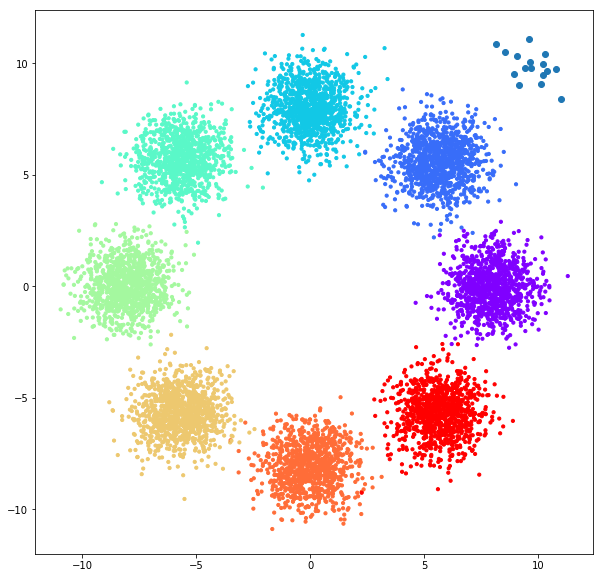

In [3]:
x, y = datagen(N=2**13, K=8)
scatter(x, y)
c = np.random.randn(16,2) + 10.
plt.scatter(c[:,0], c[:,1])

## Hard EM

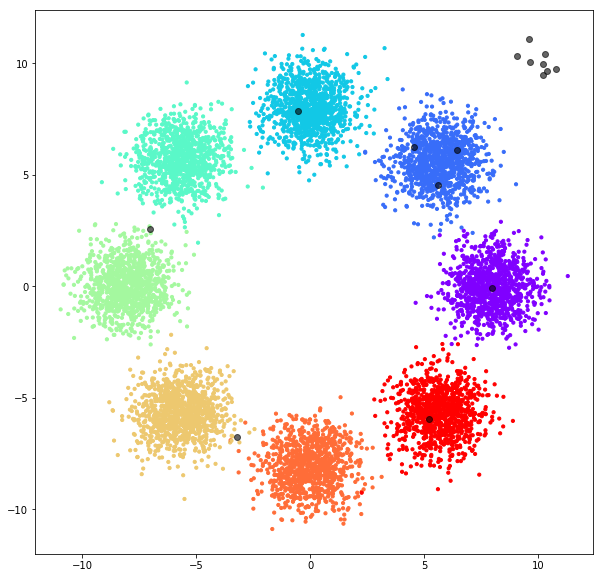

In [4]:
d = c.copy()

for i in range(500):
    d_sq = np.sum(d**2, 1, keepdims=True)
    x_sq = np.sum(x**2, 1, keepdims=True)
    dist_sq = d_sq + x_sq.T - 2 * np.dot(d, x.T)

    z = dist_sq.argmin(0)

    for i in range(d.shape[0]):
        x_z = x[z==i]
        if len(x_z) == 0:
            continue
        d[i] = x_z.mean(0)

scatter(x, y)
plt.scatter(d[:,0], d[:,1], c='k', alpha=.6)

## Soft EM

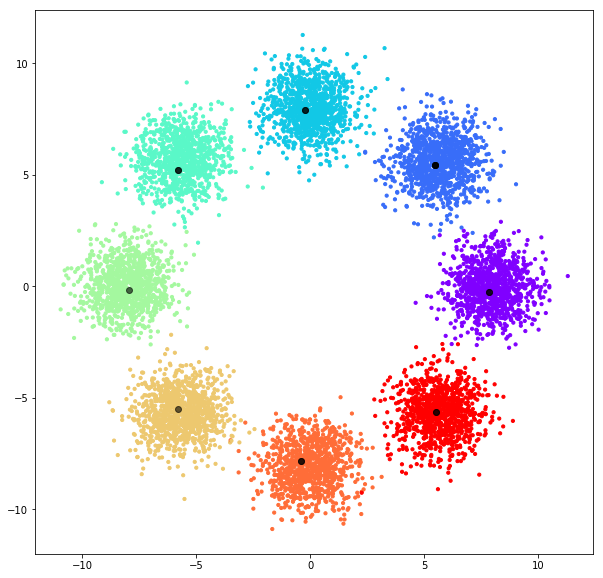

In [5]:
d = c.copy()

for i in range(500):
    d_sq = np.sum(d**2, 1, keepdims=True)
    x_sq = np.sum(x**2, 1, keepdims=True)
    dist_sq = d_sq + x_sq.T - 2 * np.dot(d, x.T)

    q_d = np.exp(-0.1 * dist_sq) / (2 * np.pi)
    q_d = q_d / np.sum(q_d, 0, keepdims=True)

    d = np.sum(np.expand_dims(q_d, -1) * np.expand_dims(x, 0), 1) / np.sum(q_d, 1, keepdims=True)

scatter(x, y)
plt.scatter(d[:,0], d[:,1], c='k', alpha=.6)

## Soft EM with SGD (Proposed Method)

In [6]:
tf.enable_eager_execution()

points = tf.constant(x, dtype=tf.float32)
centroids = tf.Variable(c, dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(1e-2)
cs = [centroids.numpy()]

In [7]:
for e in range(10 - len(cs)):
    for i in range(1000):
      with tf.GradientTape() as tape:
        d_sq = tf.reduce_sum(centroids**2, 1, keepdims=True)
        x_sq = tf.reduce_sum(points**2, 1, keepdims=True)
        dist_sq = d_sq + tf.transpose(x_sq) - 2 * tf.matmul(centroids, points, transpose_b=True)

        q_d = tf.stop_gradient(tf.math.softmax(-0.1 * dist_sq, axis=0))
        loss = -tf.reduce_sum(-0.1 * dist_sq * q_d)
      gradients = tape.gradient(loss, [centroids])
      optimizer.apply_gradients(zip(gradients, [centroids]))
    cs.append(centroids.numpy())
    print(loss.numpy())

15766.547
5947.636
4245.3174
3806.7388
3677.2434
3680.6177
3681.3398
3681.3848
3681.3855


<Figure size 432x288 with 0 Axes>

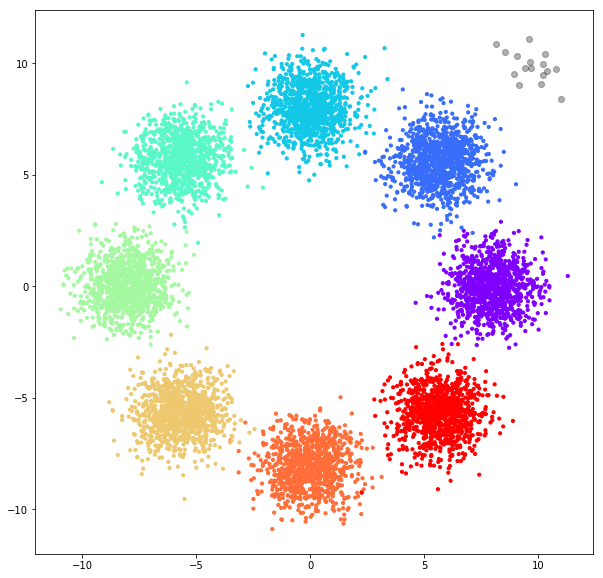

<Figure size 432x288 with 0 Axes>

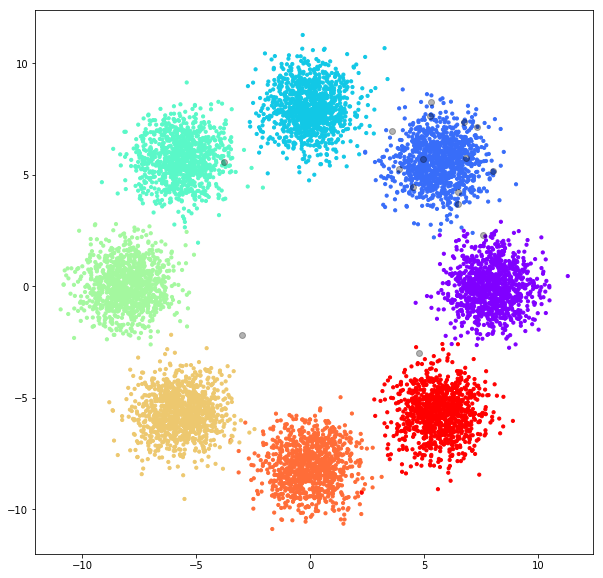

<Figure size 432x288 with 0 Axes>

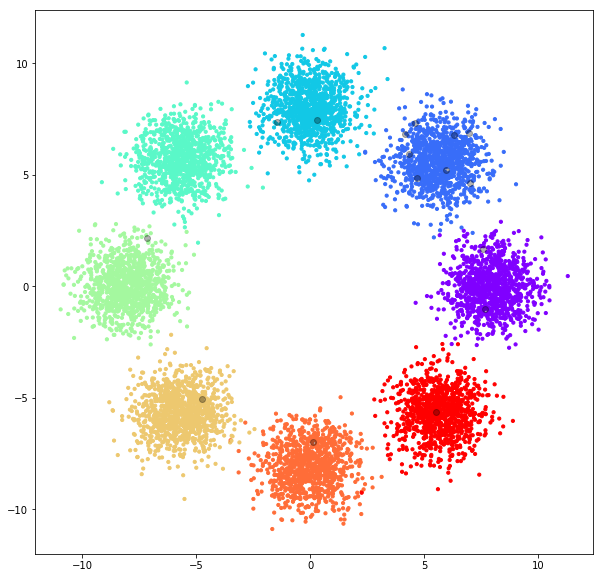

<Figure size 432x288 with 0 Axes>

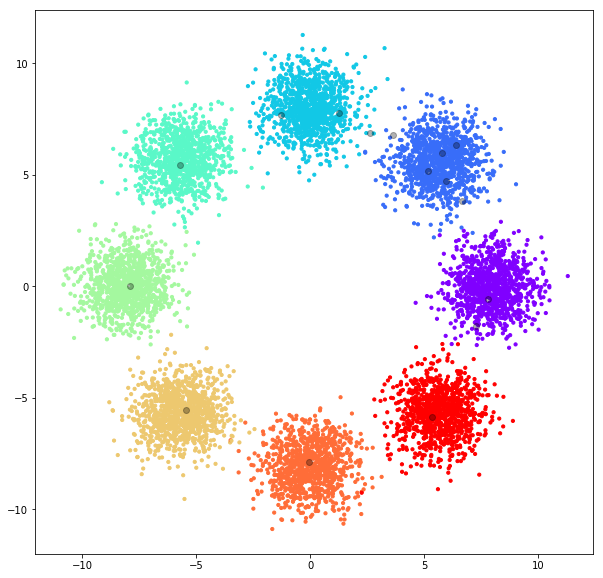

<Figure size 432x288 with 0 Axes>

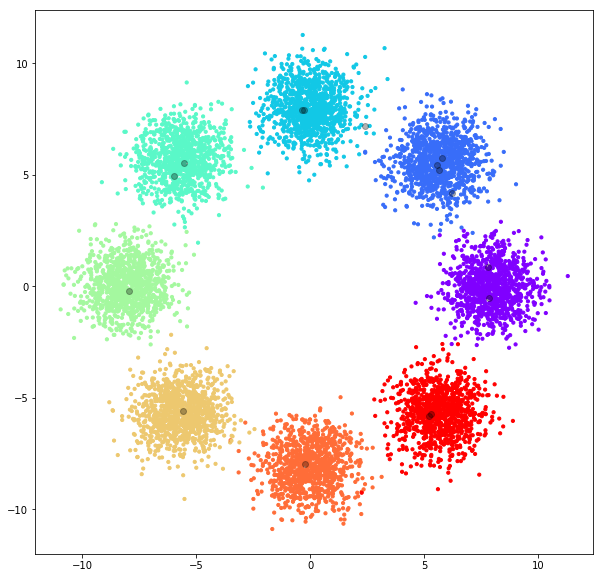

<Figure size 432x288 with 0 Axes>

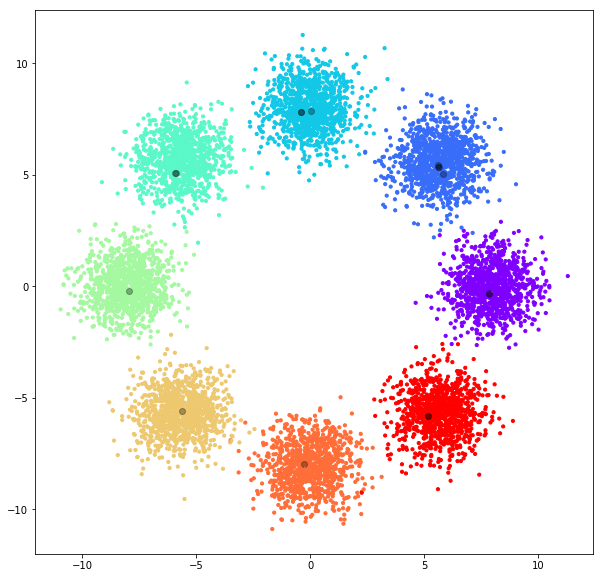

<Figure size 432x288 with 0 Axes>

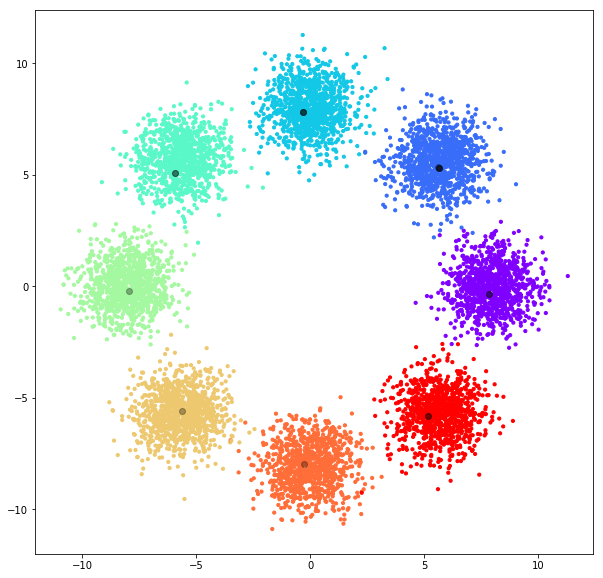

<Figure size 432x288 with 0 Axes>

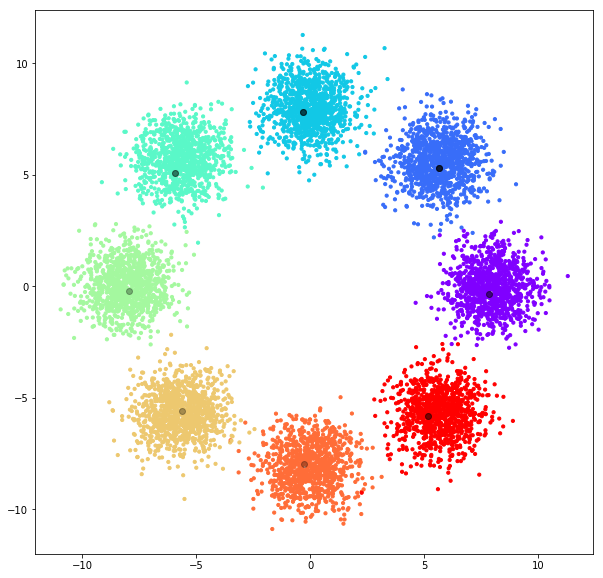

<Figure size 432x288 with 0 Axes>

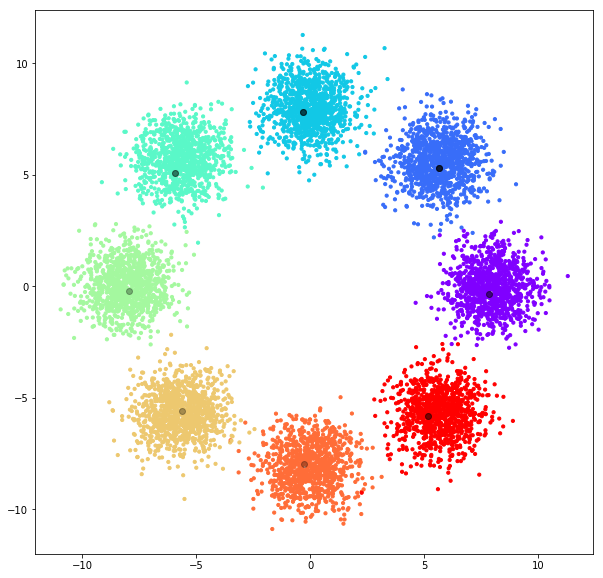

<Figure size 432x288 with 0 Axes>

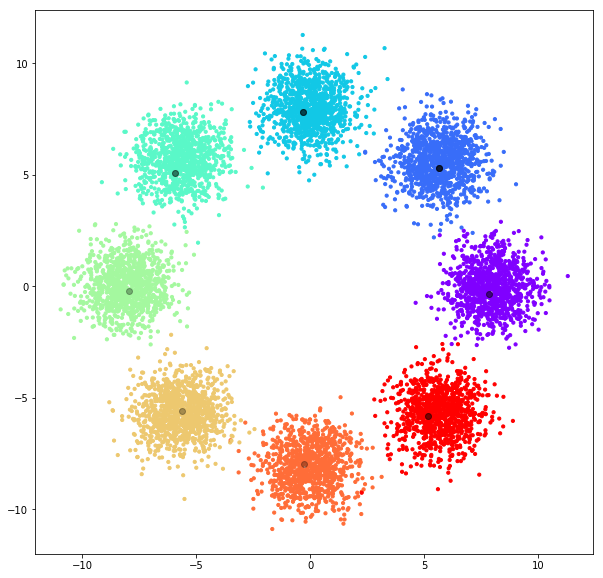

In [8]:
for i in range(len(cs)):
    plt.figure()
    c_np = cs[i]
    scatter(x, y)
    plt.scatter(c_np[:,0], c_np[:,1], c='k', alpha=.3)